# **TP: Adversarial Attacks on Face Recognition Systems**
- **Nom: Massyl Yanis HAMDI**
- **Num: 21118208**

## **Description**

The aim of this practical session is to train some simple face classifiers and test their vulnerabilities.

## **Questions**

### 0.  Enable the GPU by going to **Edit** + **Notebook Settings** where you can change the hardware accelerator from CPU to T4 GPU. Then, run the following.

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import WeightedRandomSampler
from sklearn.datasets import fetch_lfw_people
import torchvision.utils
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch import optim
from collections import defaultdict
from IPython.display import clear_output
from pdb import set_trace as bp

class LFW(Dataset):
  def __init__(self, transform=transforms.Compose([transforms.ToTensor(),transforms.Resize((100,100))]), chunk=None):
    # lfw_people, automatic download
    self.lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=1)
    _, self.h, self.w = self.lfw_people.images.shape
    self.classes = self.lfw_people.target_names

    # transformation for dataaug
    self.transform = transform

    # chunking
    self.indices = get_chunk(self.lfw_people.target, chunk)

    # samples (images and labels)
    self.images = self.lfw_people.images[self.indices]
    self.labels = self.lfw_people.target[self.indices]

    # indices per class
    self.indices_per_class = indices_per_class(self.labels)

  def __getitem__(self, index):
    #Returns a transformed image and a label
    if index >= self.__len__():
      raise IndexError('list index out of range')
    img, label = self.images[index], self.labels[index]
    if self.transform is not None:
      img = self.transform(img)
    return img, label

  def __len__(self):
    return len(self.labels)

### 1.  Create the function **indices_per_class** that takes as input a list $L$ of integers and outputs a dictionary $D$, where, for an integer $i$, $D[i]$ is the list of indices $j$ of $L$ such that $L[j]=i$.

In [2]:
def indices_per_class(L):
  """
  Renvoie un dictionnaire contenant les indices de chaque valeur unique dans une liste donnée.

  Args:
  L (list): Liste d'entiers.

  Returns:
  dict: Dictionnaire où chaque clé est une valeur unique de la liste et chaque valeur est une liste d'indices correspondants.

  Exemple:
  >>> List = [1, 0, 0, 1, 1, 1, 0, 0]
  >>> indices_per_class(List)
  {0: [1, 2, 6, 7], 1: [0, 3, 4, 5]}

  """
  D = {}
  bib = np.unique(L)
  for i  in bib:
    D[i] = np.where(L == i)[0].tolist()
  return D

### 2.  Create the function **get_chunk** that returns the indices according to the chunk used. $$$$ **If chunk == 'test'**, we aim to have the first 10 images for each class (dataset size = 70). $$$$ **If chunk == 'val'**, we aim to have the next 10 images for each class (dataset size = 70). $$$$ **If chunk == 'train'**, we aim to have the remaining images (dataset size = 1148). $$$$ Check that **LFW_test** and **LFW_val** (the LFW class initiated with chunk='test' and 'val' respectively) are perfectly balanced. Plot 4 samples of each individual from the test dataset (i.e., show each time the image and the label).

In [3]:
def get_chunk(Label, chunk):
  """
    Fonction qui retourne l'index des données à utiliser pour l'entraînement, la validation ou le test.

    Paramètres :
    - Label : liste des labels de chaque donnée
    - chunk : chaîne de caractères indiquant le jeu de données à retourner ('test', 'val' ou 'train')

    Retourne :
    - index : liste des index des données à utiliser pour le jeu de données sélectionné
  """
  bib_index = indices_per_class(Label)
  index = []

  for i in bib_index:
    if chunk == 'test':
        index.append(bib_index[i][: 10])
    elif chunk == 'val':
        index.append(bib_index[i][10:20])
    elif chunk == 'train':
        index.append(bib_index[i][20 :])
  index = [item for sublist in index for item in sublist]
  return index

In [4]:
# Récupération des données de test et de validation de la base LFW
LFW_test = LFW(chunk = 'test')
LFW_val = LFW(chunk = 'val')

# Affichage de la taille des bases de test et de validation
print(f"la taille de la base de test : {len(LFW_test)}")
print(f"la taille de la base de val : {len(LFW_val)}")


la taille de la base de test : 70
la taille de la base de val : 70


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


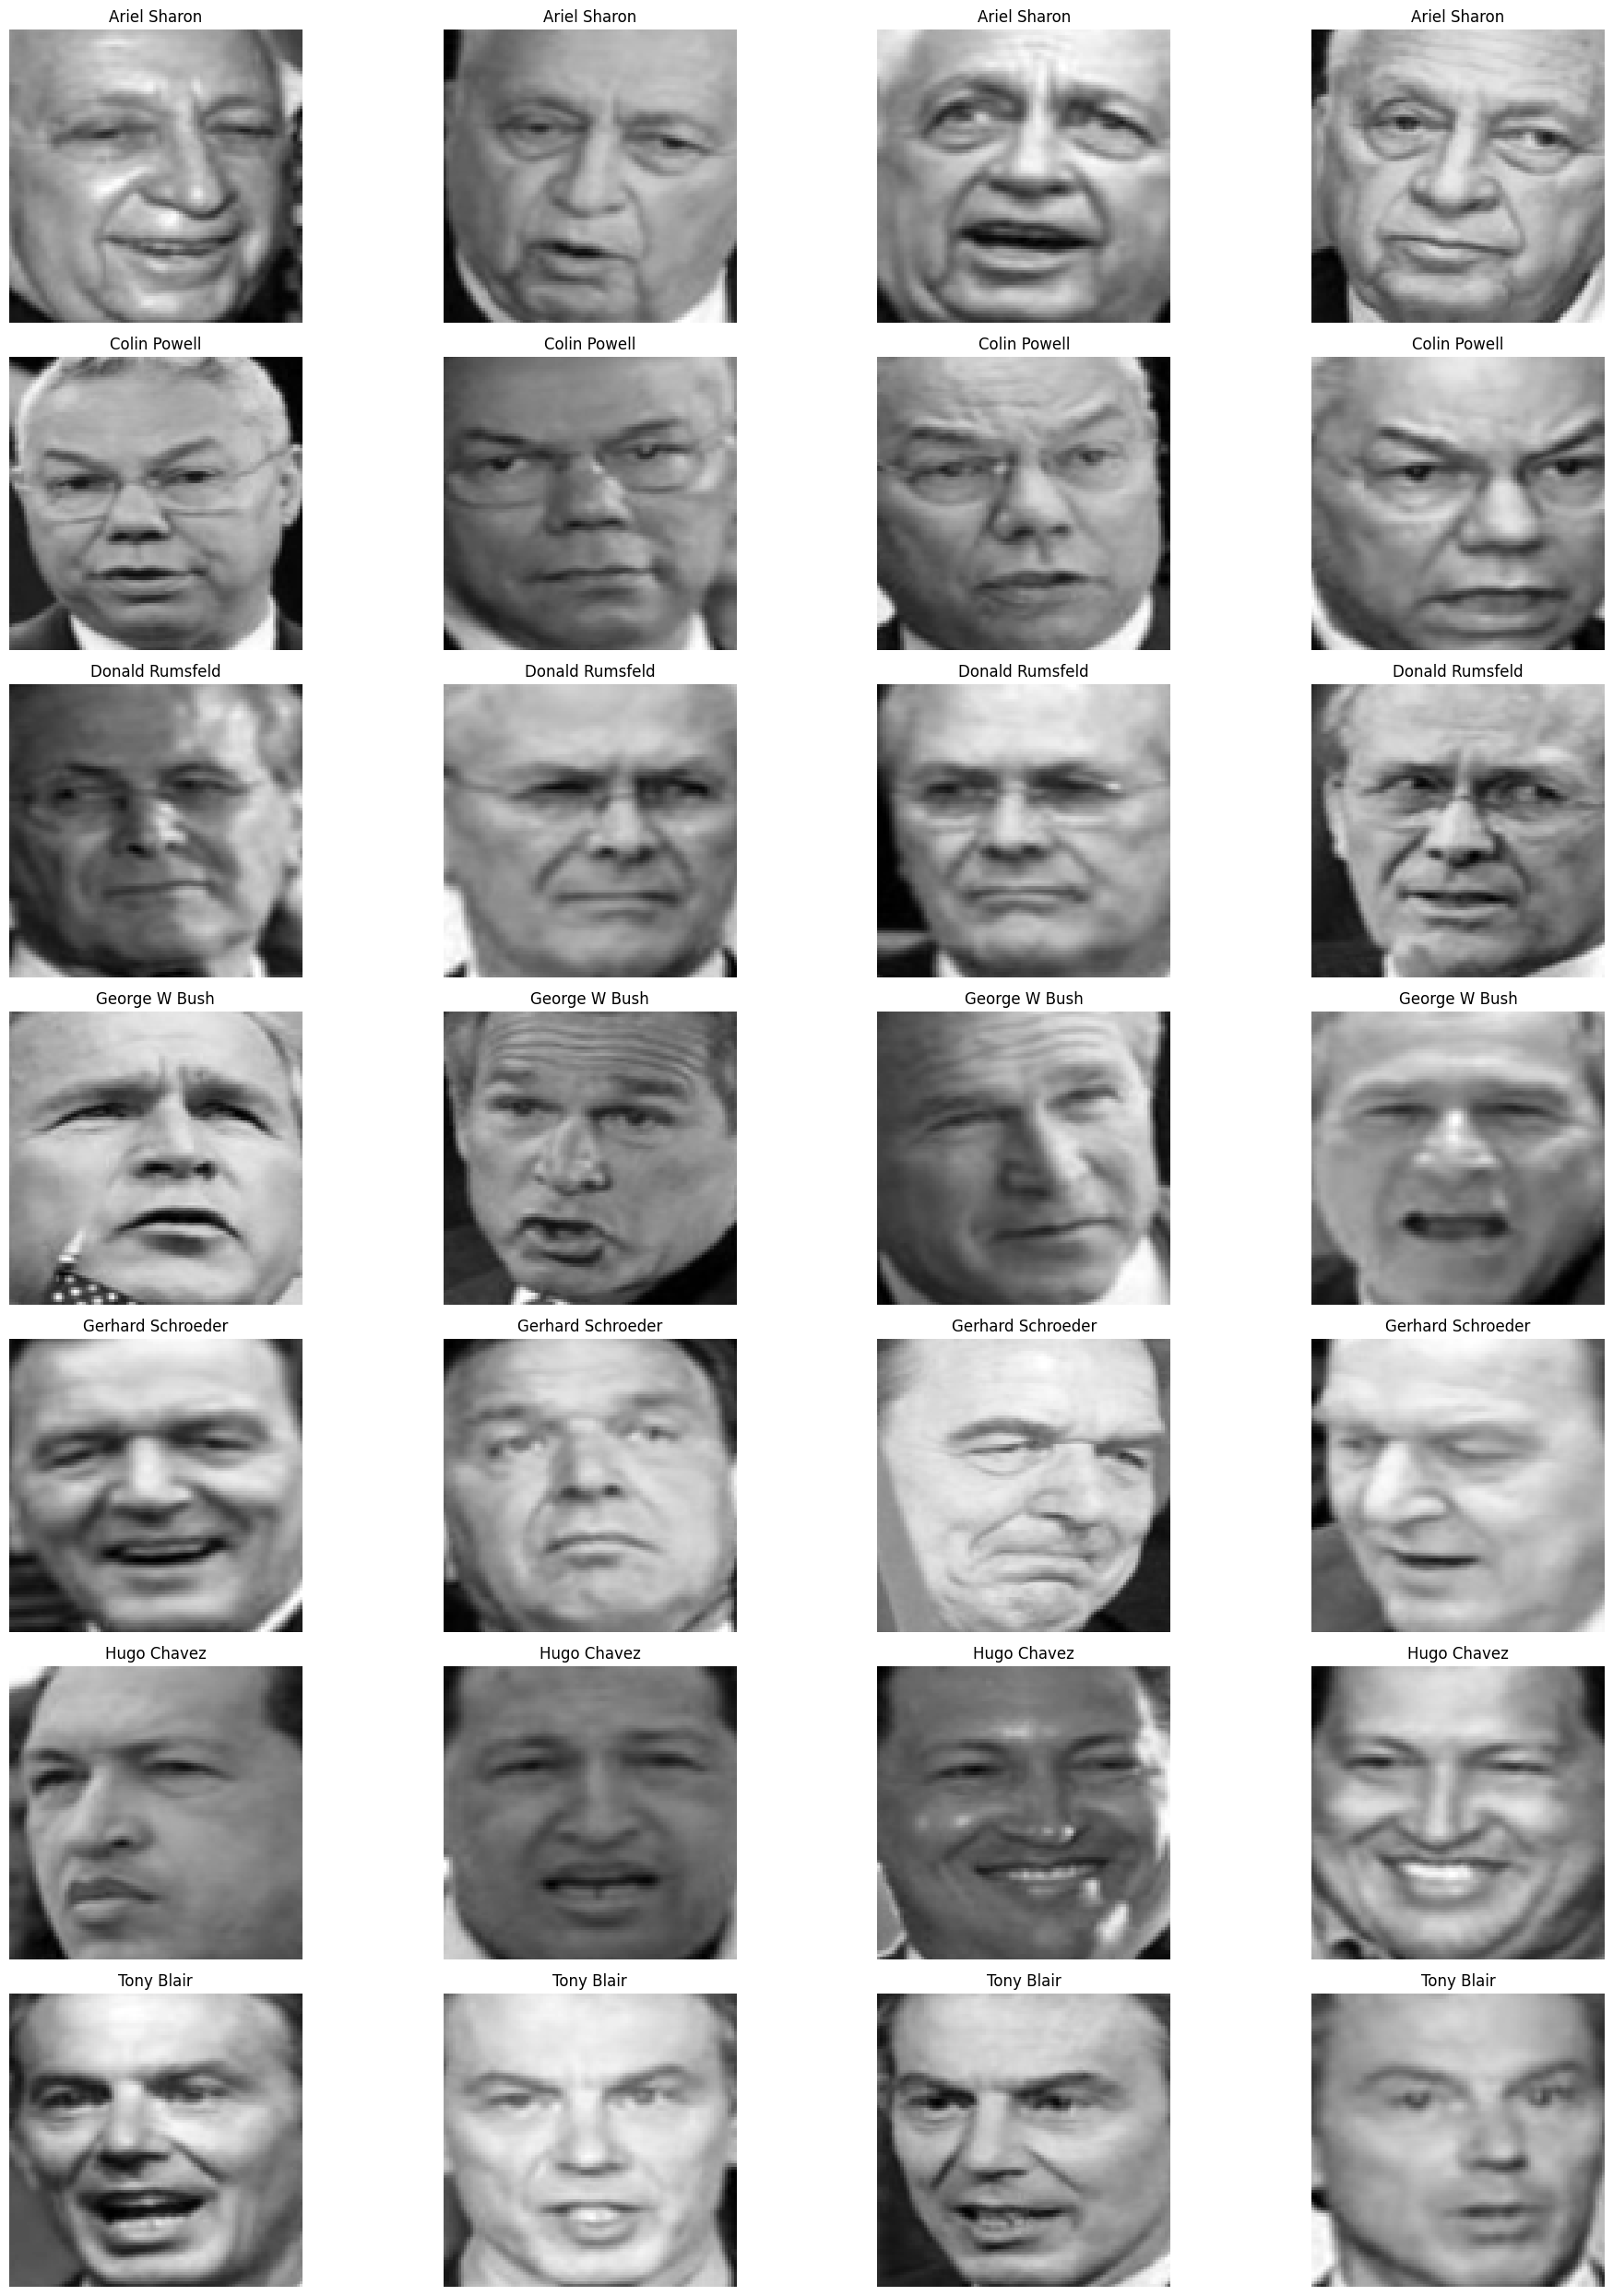

In [5]:
import math
# Génération des indices des données à récupérer
indices = [i for i in range(0, 70, 10)]
indices = [(i + j) for i in indices for j in range(4)]

# Récupération des images et des labels correspondants
imgs = [LFW_test[i][0].reshape(100, 100) for i in indices]
labels = [LFW_test[i][1] for i in indices]

# Création de la figure
plt.figure(figsize=(20, 25))

# Affichage des images avec leurs titres
for i, (img, title) in enumerate(zip(imgs, labels)):
    plt.subplot(7,4, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(LFW_test.classes[title])
    plt.axis('off')


plt.tight_layout()
plt.show()


### 3. Create **LFW_train**, an instance of the class LFW where chunk='train', adding some random data augmentation after the default transforms. Show several examples to ensure that the dataaug is not too severe. Then, using **torch.utils.data.sampler.WeightedRandomSampler**, create a **train_dataloader**, ensuring that it is balanced, i.e. that each class is seen, in expectation, the same number of times during an epoch.

In [6]:
transforms_ = transforms.Compose([
    transforms.ToTensor(),  # Convertit l'image en tenseur
    transforms.Resize((100, 100)),  # Redimensionne l'image en 100x100 pixels
    transforms.RandomHorizontalFlip(p=0.5),  # Effectue une rotation horizontale aléatoire avec une probabilité de 0.5
    # transforms.RandomRotation(degrees=90)  # Effectue une rotation aléatoire avec un angle maximum de 90 degrés
])

LFW_train = LFW(transform=transforms_, chunk='train')

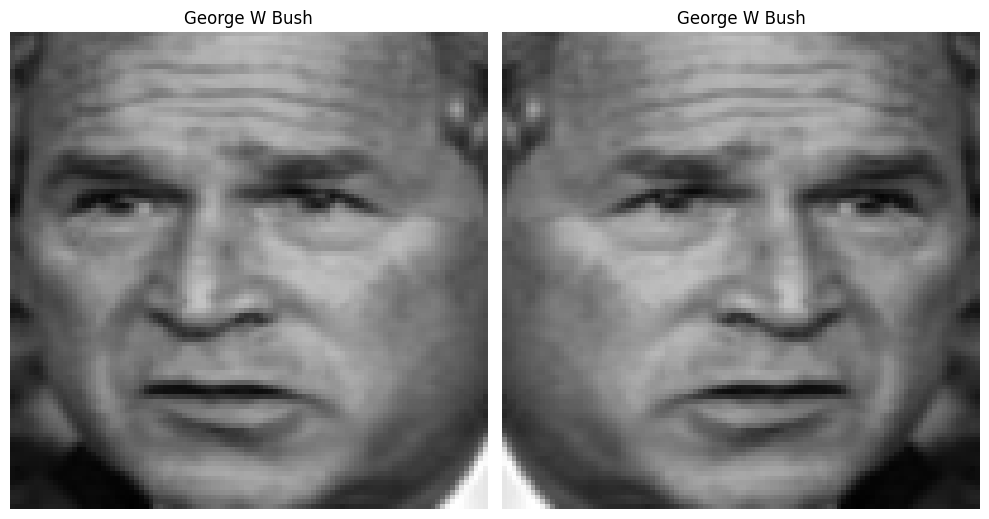

In [7]:
indice = random.randint(0, 1148)
while True:
  # Récupération de la première et de la deuxième image avec leur label correspondant
  img1, label1 = LFW_train[indice]
  img2, label2 = LFW_train[indice]

  # Création d'une liste d'images et de labels
  image_ = [img1, img2]
  label_ = [label1, label2]

  if not (img1 == img2).all():
          break

# Création de la figure
plt.figure(figsize=(10, 10), tight_layout=True)

# Affichage des images avec leurs titres
for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.imshow(image_[i].reshape(100, 100), cmap='gray')
    plt.title(LFW_test.classes[label_[i]])
    plt.axis('off')

plt.tight_layout()
plt.show()


In [8]:
# Récupération des indices par classe dans LFW_train
D = LFW_train.indices_per_class

# Calcul des poids pour chaque classe
weight = [(1./len(D[i])) for i in LFW_train.labels]

# Conversion des poids en tenseur
samples_weight = torch.from_numpy(np.array(weight))

# Création d'un échantillonneur pondéré aléatoire
sampler = WeightedRandomSampler(samples_weight, num_samples=len(LFW_train))

# Création du DataLoader pour LFW_train
train_loader = DataLoader(LFW_train, batch_size=64, sampler=sampler)


<ipython-input-49-d53447048e16>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


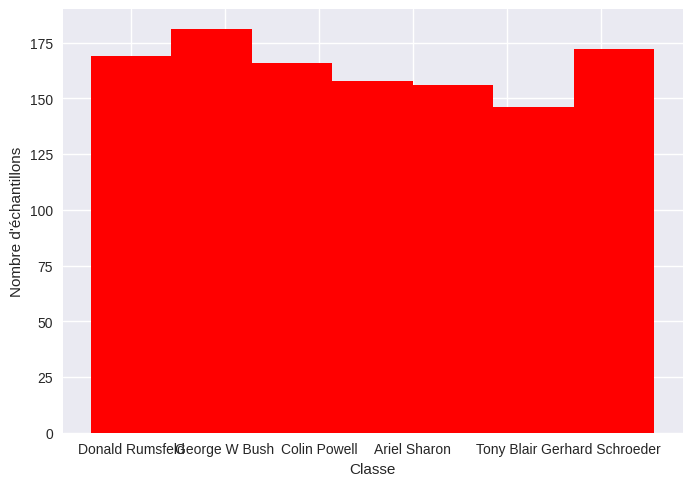

In [49]:
# Création d'une liste vide pour stocker les labels
labels = []

# Parcours des batches dans le DataLoader
for _, batch_labels in train_loader:
    # Ajout des labels de chaque batch à la liste
    labels += batch_labels.tolist()
import seaborn as sns

# Tracer l'histogramme
plt.hist(LFW_train.classes[labels], bins=len(LFW_train.classes), color='red',align='left')

plt.xlabel('Classe')
plt.ylabel('Nombre d\'échantillons')
plt.style.use('seaborn')

plt.show()


###4. Write a single function **metrics**, taking as input two $n$-dimensional vectors $(gt,pred)$ (i.e., the labels and the predictions) and computing the overall classification accuracy and the per-class precision, recall and F1-measure. Here are the definitions of those metrics:
$$Accuracy = \frac{1}{n}\sum_{i=1}^n \mathbb{I}\{gt_i=pred_i\},\quad Precision_{cl} = \frac{\sum_{i=1}^n \mathbb{I}\{gt_i=pred_i=cl\}}{\sum_{i=1}^n \mathbb{I}\{pred_i=cl\}},$$
$$Recall_{cl} = \frac{\sum_{i=1}^n \mathbb{I}\{gt_i=pred_i=cl\}}{\sum_{i=1}^n \mathbb{I}\{gt_i=cl\}}, \quad F_1score_{cl} = \frac{2}{1/Precision_{cl} + 1/Recall_{cl}}.$$

In [10]:
def metrics(gt, pred):
    """
    Calcule les métriques de performance pour une classification binaire.

    Args:
        gt (list): Liste des vraies valeurs (ground truth).
        pred (list): Liste des valeurs prédites.

    Returns:
        tuple: Un tuple contenant les métriques suivantes dans l'ordre :
               accuracy (précision globale), precision (précision), recall (rappel), f1-score (score F1).
    """

    # Calcul de l'exactitude globale
    accuracy = sum([1 for i in range(len(gt)) if gt[i] == pred[i]]) / len(gt)

    # Calcul des métriques pour chaque classe
    classes = list(set(gt))
    precision = {}
    recall = {}
    f1_score = {}
    for cl in range(7):
        # Calcul de la précision
        tp = sum([1 for i in range(len(gt)) if gt[i] == cl and pred[i] == cl])
        fp = sum([1 for i in range(len(gt)) if pred[i] == cl and gt[i] != cl])
        precision[cl] = tp / (tp + fp) if tp + fp > 0 else 0

        # Calcul du rappel
        fn = sum([1 for i in range(len(gt)) if gt[i] == cl and pred[i] != cl])
        recall[cl] = tp / (tp + fn) if tp + fn > 0 else 0

        # Calcul du score F1
        f1_score[cl] = 2 / (1 / precision[cl] + 1 / recall[cl]) if precision[cl] + recall[cl] > 0 else 0

    return accuracy, precision, recall, f1_score


### 5. Run the following code.

In [28]:
class ConvNet(nn.Module):
    """Basic ConvNet Conv(1, 32, 64) -> FC(100, 7) -> softmax."""
    def __init__(self, in_channels=1, n_outputs=7):
        super(ConvNet, self).__init__()

        # CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(in_channels, 96, kernel_size=11,stride=4),       # H=W=100 -> floor(1+(100-11)/4) = 23
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),                       # 23 -> floor(1+(23-3)/2) = 11

            nn.Conv2d(96, 256, kernel_size=5, stride=1),     # 11 -> floor(1+(11-5)/1) = 7
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),                       # 7 -> floor(1+(7-2)/2) = 3

            nn.Conv2d(256, 384, kernel_size=3,stride=1),     # 3 -> floor(1+(3-3)/1) = 1
            nn.ReLU(inplace=True)
        )

        # Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),

            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),

            nn.Linear(256,n_outputs)
        )

    def forward(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

class Resnet18(nn.Module):
    """ResNet 18, pretrained, with one input chanel and 7 outputs."""
    def __init__(self, in_channels=1, n_outputs=7):
        super(Resnet18, self).__init__()

        # self.model = torchvision.models.resnet18()
        self.model = torchvision.models.resnet18(pretrained=True)

        self.model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2,
                                     padding=3, bias=False)

        # Last layer
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, n_outputs)

    def forward(self, x):
        return self.model(x)

class MyNet(nn.Module):
    def __init__(self, in_channels=1, n_outputs=7):
        super(MyNet, self).__init__()
        # CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(in_channels, 128, kernel_size=11,stride=4),       # H=W=100 -> floor(1+(100-11)/4) = 23
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),                       # 23 -> floor(1+(23-3)/2) = 11

            nn.Conv2d(128, 256, kernel_size=5, stride=1),     # 11 -> floor(1+(11-5)/1) = 7
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),                       # 7 -> floor(1+(7-2)/2) = 3

            nn.Conv2d(256, 384, kernel_size=3,stride=1),     # 3 -> floor(1+(3-3)/1) = 1
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True)
        )
        # Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(384, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),

            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),

            nn.Linear(256, n_outputs)
        )

    def forward(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output




def live_plot(data_dict, figsize=(7,5), title=''):
    """function for sequentially updating a plot"""
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    for label,data in data_dict.items():
        plt.plot(data, label=label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.legend(loc='center left') # the plot evolves to the right
    plt.show()

def train_loop(train_dataloader, val_data, Net, metrics, Loss,
               lr=0.0005,
               n_epoch=50):
    """A simple train loop"""

    # val dataloader
    val_dataloader = DataLoader(val_data)

    # init plots
    to_plot = {'train loss': [], 'val loss': [], 'val accuracy': []}

    # net and optim
    gpu = torch.cuda.device_count()
    if gpu:
        print('using GPU')
        net = Net().cuda()
    else:
        print('using CPU')
        net = Net()
    optimizer = optim.Adam(net.parameters(), lr = lr)

    # checkpoint
    best_checkpoint = {'val accuracy' : 0, 'epoch': 0, 'checkpoint' : None}

    # Iterate throught the epochs
    for epoch in range(n_epoch):

        # init loss recording
        train_losses = []

        # put the net on train mode
        net.train()

        # Iterate over batches
        for img, label in train_dataloader:

            # Send the images and labels to CUDA
            if gpu:
                img, label = img.cuda(), label.cuda()

            # Zero the gradients
            optimizer.zero_grad()

            # Pass in the two images into the network and obtain two outputs
            output = net(img)

            # Pass the outputs of the networks and label into the loss function
            train_loss = Loss(output, label)

            # Calculate the backpropagation
            train_loss.backward()

            # Optimize
            optimizer.step()

            # record train loss
            with torch.no_grad():
                train_losses.append(train_loss.item())

        with torch.no_grad():
            to_plot['train loss'].append(np.mean(train_losses))

            # validation
            val_records = {'gt': [], 'pred': []}
            val_losses = []
            net.eval()
            for img, label in val_dataloader:
                if gpu:
                    img, label = img.cuda(), label.cuda()
                output = net(img)
                val_losses.append(Loss(output,label).item())
                val_records['gt'].append(int(label.cpu()))
                val_records['pred'].append(int(torch.argmax(output,1).cpu()))
            to_plot['val loss'].append(np.mean(val_losses))

            # metrics
            accuracy, precision, recall, f1_score = metrics(np.array(val_records['gt']),np.array(val_records['pred']))
            # print(accuracy, precision, recall, f1_score)
            to_plot['val accuracy'].append(accuracy)

        # plots
        live_plot(to_plot)

        # checkpoint selection via validation
        if best_checkpoint['val accuracy']<accuracy:
            best_checkpoint['val accuracy'] = accuracy
            best_checkpoint['epoch'] = epoch
            best_checkpoint['checkpoint'] = net.state_dict()

    print(f"checkpoint generated from epoch {best_checkpoint['epoch']}, with val accuracy {best_checkpoint['val accuracy']}")
    return best_checkpoint['checkpoint']

def test(model, test_loader, checkpoint):
  model.load_state_dict(checkpoint)
  model.eval()

  preds = []
  targets = []

  with torch.no_grad():
      for data, target in test_loader:
          output = model(data)
          pred = output.argmax(1, keepdim=True) # get the index of the max log-probability
          preds.append(pred)
          targets.append(target)
  score_metrics = metrics(targets,preds)
  return score_metrics

### 6. Call **train_loop(train_loader, LFW_val, net, metrics, loss)** to produce a checkpoint, for net $\in$ {ConvNet, Resnet18, YourNet = another network that you designed}.

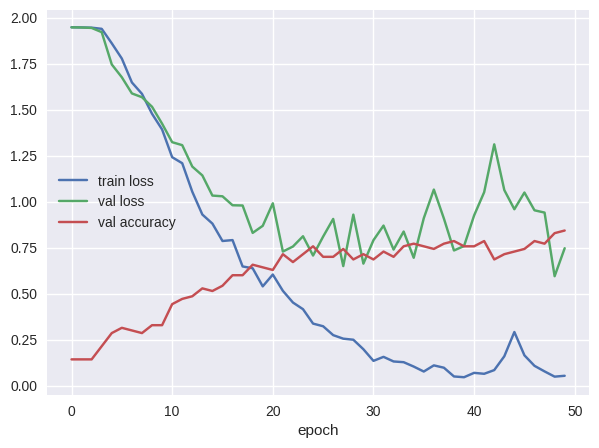

checkpoint generated from epoch 49, with val accuracy 0.8428571428571429


In [29]:
Loss = nn.CrossEntropyLoss()
checkpoint_convnet = train_loop(train_loader, LFW_val, ConvNet, metrics, Loss)


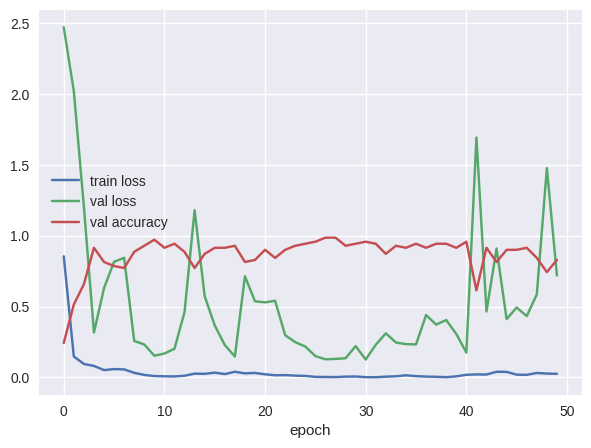

checkpoint generated from epoch 26, with val accuracy 0.9857142857142858


In [30]:
checkpoint_Resnet18 = train_loop(train_loader, LFW_val, Resnet18, metrics, Loss)

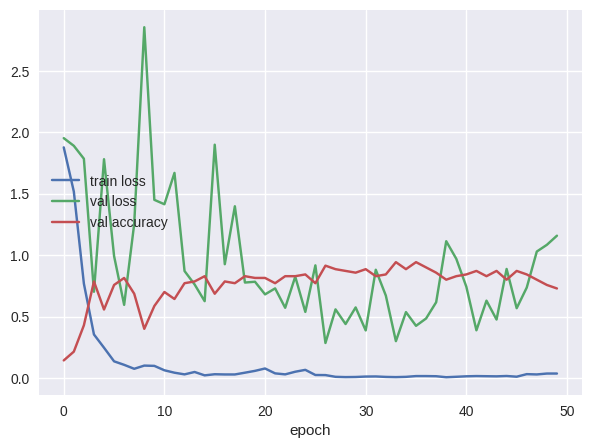

checkpoint generated from epoch 33, with val accuracy 0.9428571428571428


In [31]:
checkpoint_Mynet = train_loop(train_loader, LFW_val, MyNet, metrics, Loss)

### 7. Visualize some test (image, label) pairs with the associated score that the network outputs. Evaluate the output checkpoints on **LFW_test** and repport the metrics in an array as
$$\begin{array}{ |c|c|c| }
\hline
\text{model} &\text{accuracy}& \text{class 0 pre./ rec./ f1}&\dots&\text{class 6 pre./ rec./ f1}\\
\hline
\color{blue}{\text{ConvNet}}&?&?/?/?&\dots&?/?/?\\
\hline
\color{blue}{\text{Resnet18}}&?&?/?/?&\dots&?/?/?\\
\hline
\color{blue}{\text{YourNet}}&?&?/?/?&\dots&?/?/?\\
\hline
\end{array}$$

In [32]:
test_dataloader = DataLoader(LFW_test)
eval_convnet = test(ConvNet(), test_dataloader,checkpoint_convnet)
eval_resnet = test(Resnet18(), test_dataloader,checkpoint_Resnet18)
eval_MyNet = test(MyNet(), test_dataloader,checkpoint_Mynet)


In [33]:
from tabulate import tabulate

header = ["model", "accuracy"]
for i in range(7):
    header.append(f"class {i} pre./rec./f1.")

class_info = []

models = [("ConvNet", eval_convnet), ("Resnet18", eval_resnet), ("MYNet", eval_MyNet)]

for model_name, eval_results in models:
    row = [model_name, eval_results[0]]
    class_info.append(row + [f"{eval_results[1][i]:.2f} / {eval_results[2][i]:.2f} / {eval_results[3][i]:.2f}" for i in range(7)])

print(tabulate(class_info, headers=header, tablefmt="grid"))


+----------+------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
| model    |   accuracy | class 0 pre./rec./f1.   | class 1 pre./rec./f1.   | class 2 pre./rec./f1.   | class 3 pre./rec./f1.   | class 4 pre./rec./f1.   | class 5 pre./rec./f1.   | class 6 pre./rec./f1.   |
+==========+============+=========================+=========================+=========================+=========================+=========================+=========================+=========================+
| ConvNet  |   0.771429 | 1.00 / 0.50 / 0.67      | 0.83 / 1.00 / 0.91      | 0.91 / 1.00 / 0.95      | 0.64 / 0.70 / 0.67      | 0.57 / 0.80 / 0.67      | 1.00 / 0.80 / 0.89      | 0.67 / 0.60 / 0.63      |
+----------+------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------

### 8. Train a siamese model for this classification task and compare it to the previous models on the test dataset. In particular: $$$$ $(i)$ Create a train dataloader producing pairs of images, with approximately 50% of the samples being pairs of the same class. $$$$ $(ii)$ Create a siamese network taking two images as input and obtaining two feature vectors by passing each image through the same network. $$$$ $(iii)$ Use a contrastive loss to train this model.

this code is based on: https://github.com/delijati/pytorch-siamese/tree/master

In [35]:
class Siamese_LFW(Dataset):
  def __init__(self, transform=transforms.Compose([transforms.ToTensor(),transforms.Resize((100,100))]), size=10000):
    # lfw_people, téléchargement automatique
    self.lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=1)
    _, self.h, self.w = self.lfw_people.images.shape
    self.classes = self.lfw_people.target_names

    # transformation pour dataaug
    self.transform = transform

    # échantillons (images et étiquettes)
    self.images = self.lfw_people.images
    self.labels = self.lfw_people.target

    # Crée des paires d'images similaires et différentes
    self.pairs_same, self.pairs_diff = self.create_pairs()

    # Mélange aléatoirement les paires
    np.random.shuffle(self.pairs_same)
    np.random.shuffle(self.pairs_diff)

    # Sélectionne un nombre donné de paires
    self.pairs_same = self.pairs_same[:size]
    self.pairs_diff = self.pairs_diff[:size]

    samples = []
    labels = []
    for i in range(min(len(self.pairs_same), len(self.pairs_diff))):
        samples.append((self.images[self.pairs_same[i][0]], self.images[self.pairs_same[i][1]]))
        labels.append(1)
        samples.append((self.images[self.pairs_diff[i][0]], self.images[self.pairs_diff[i][1]]))
        labels.append(0)
    self.samples = samples
    self.labels = labels

  def create_pairs(self):
    """Crée des paires d'images similaires et différentes"""
    pairs_same = []
    pairs_diff = []

    for i in range(len(self.labels)):
      for j in range(i+1, len(self.labels)):
        if self.labels[i] == self.labels[j]:
          pairs_same.append((i, j))
        else:
          pairs_diff.append((i, j))

    return pairs_same, pairs_diff

  def __getitem__(self, index):
    """Retourne une paire d'images et son étiquette"""
    if index >= self.__len__():
      raise IndexError('list index out of range')

    img1, img2 = self.samples[index]
    label = self.labels[index]
    if self.transform is not None:
      img1 = self.transform(img1)
      img2 = self.transform(img2)

    return img1, img2, label

  def __len__(self):
    """Retourne le nombre total de paires d'images"""
    return len(self.samples)


In [36]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.

    Based on: https://github.com/delijati/pytorch-siamese/tree/master
    """

    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin


    def forward(self, x0, x1, y):


        # euclidian distance
        diff = x0 - x1
        dist_sq = torch.sum(torch.pow(diff, 2), 1)
        dist = torch.sqrt(dist_sq)

        mdist = self.margin - dist
        dist = torch.clamp(mdist, min=0.0)
        loss = y * dist_sq + (1 - y) * torch.pow(dist, 2)
        loss = torch.sum(loss) / 2.0 / x0.size()[0]
        return loss


In [50]:
class siameseNet(nn.Module):
  def __init__(self, in_channels = 1, n_outputs = 128) :
      super(siameseNet, self).__init__()
      self.model = torchvision.models.resnet18(pretrained=True)

      self.model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=5, stride=2,
                                    padding=3, bias=False)

      # Last layer
      num_ftrs = self.model.fc.in_features
      self.model.fc = nn.Linear(num_ftrs, n_outputs)

  def forward_once(self, x):
      return self.model(x)

  def forward(self, input1, input2):
    output1 = self.forward_once(input1)
    output2 = self.forward_once(input2)
    return output1, output2

In [54]:
def train_loop_(train_dataloader, val_data, Net, metrics, Loss,
               lr=0.0005,
               n_epoch=10):
    """A simple train loop"""

    # val dataloader
    val_dataloader = DataLoader(val_data)

    # init plots
    to_plot = {'train loss': [], 'val loss': [], 'val accuracy': []}

    # net and optim
    gpu = torch.cuda.device_count()
    if gpu:
        print('using GPU')
        net = Net().cuda()
    else:
        print('using CPU')
        net = Net()
    optimizer = optim.Adam(net.parameters(), lr = lr)

    # checkpoint
    best_checkpoint = {'val accuracy' : 0, 'epoch': 0, 'checkpoint' : None}

    # Iterate throught the epochs
    for epoch in range(n_epoch):

        # init loss recording
        train_losses = []

        # put the net on train mode
        net.train()

        # Iterate over batches
        for img1, img2 , label in train_dataloader:

            # Send the images and labels to CUDA
            if gpu:
                img1, img2, label = img1.cuda(), img2.cuda(), label.cuda()

            # Zero the gradients
            optimizer.zero_grad()

            # Pass in the two images into the network and obtain two outputs
            output1, output2 = net(img1, img2)

            # Pass the outputs of the networks and label into the loss function

            train_loss = Loss(output1, output2, label)

            # Calculate the backpropagation
            train_loss.sum().backward()

            # Optimize
            optimizer.step()

            # record train loss
            with torch.no_grad():
                train_losses.append(train_loss.mean().item())

        with torch.no_grad():
            to_plot['train loss'].append(np.mean(train_losses))

            # validation
            val_records = {'gt': [], 'pred': []}
            val_losses = []
            net.eval()
            for img1, img2 , label in val_dataloader:
                if gpu:
                    img1, img2, label = img1.cuda(), img2.cuda(), label.cuda()
                output1, output2 = net(img1, img2)
                output = torch.sqrt(torch.sum(torch.pow((output1-output2), 2), 1))
                val_losses.append(Loss(output1, output2,label).item())
                val_records['gt'].append(int(label.cpu()))
                val_records['pred'].append((output[0] < 0.5).cpu())
            to_plot['val loss'].append(np.mean(val_losses))

            # metrics
            accuracy, precision, recall, f1_score = metrics(np.array(val_records['gt']),np.array(val_records['pred']))
            # print(accuracy, precision, recall, f1_score)
            to_plot['val accuracy'].append(accuracy)

        # plots
        live_plot(to_plot)

        # checkpoint selection via validation
        if best_checkpoint['val accuracy']<accuracy:
            best_checkpoint['val accuracy'] = accuracy
            best_checkpoint['epoch'] = epoch
            best_checkpoint['checkpoint'] = net.state_dict()

    print(f"checkpoint generated from epoch {best_checkpoint['epoch']}, with val accuracy {best_checkpoint['val accuracy']}")
    return best_checkpoint['checkpoint']

In [55]:
Siamese_data = Siamese_LFW()

val_size = int(0.2 * len(Siamese_data))
test_size = int(0.2 * len(Siamese_data))
train_size =len(Siamese_data) - val_size - test_size
train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(Siamese_data, [train_size, test_size, val_size])



In [56]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle = False)
Loss_ = ContrastiveLoss()

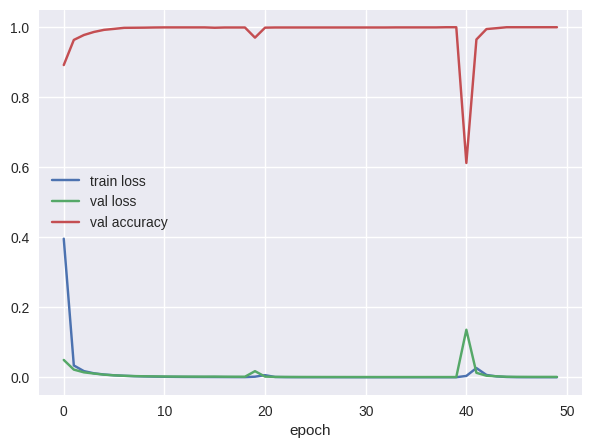

checkpoint generated from epoch 38, with val accuracy 0.999


In [57]:
checkpoint_siamese = train_loop(train_dataloader, val_dataset, siameseNet, metrics, Loss_, n_epoch=10)

### 9. For a given test image and trained checkpoint, write a function that run a white-box FGSM Attack on that model. Plot the accuracy versus epsilon plot.

In [60]:
def test(model, test_loader, checkpoint):
  model.load_state_dict(checkpoint)
  model.eval()

  preds = []
  targets = []

  with torch.no_grad():
      for img1, img2, target in test_loader:
          output1, output2= model(img1, img2)
          output = torch.sqrt(torch.sum(torch.pow((output1-output2), 2), 1))
          pred = (output[0] < 0.5)
          preds.append(pred)
          targets.append(target)
  score_metrics = metrics(targets,preds)
  return score_metrics



In [62]:
test_dataloader = DataLoader(test_dataset)
eval_Siam = test(siameseNet(), test_dataloader,checkpoint_siamese)

In [64]:
from tabulate import tabulate

header = ["model", "accuracy"]
for i in range(2):
    header.append(f"class {i} pre./rec./f1.")

class_info = []

models = [("siamese Network", eval_Siam)]

for model_name, eval_results in models:
    row = [model_name, eval_results[0]]
    class_info.append(row + [f"{eval_results[1][i]:.2f} / {eval_results[2][i]:.2f} / {eval_results[3][i]:.2f}" for i in range(2)])

print(tabulate(class_info, headers=header, tablefmt="grid"))


+-----------------+------------+-------------------------+-------------------------+
| model           |   accuracy | class 0 pre./rec./f1.   | class 1 pre./rec./f1.   |
+=================+============+=========================+=========================+
| siamese Network |    0.99975 | 1.00 / 1.00 / 1.00      | 1.00 / 1.00 / 1.00      |
+-----------------+------------+-------------------------+-------------------------+
